# **Clustering Job Descriptions Using NLP and Unsupervised Machine Learning**

#steps:

scrapping

Data Cleaning

Text Vectorization:

Clustering Algorithm:

Applied KMeans Clustering to group similar job descriptions.

Chose the number of clusters using the Elbow Method, which helps identify the point where increasing clusters gives diminishing returns.

test

save

alerting system

In [1]:
import requests
from bs4 import BeautifulSoup
import pandas as pd
import time

def scrape_karkidi_jobs(keyword="data science", pages=1):
    headers = {'User-Agent': 'Mozilla/5.0'}
    base_url = "https://www.karkidi.com/Find-Jobs/{page}/all/India?search={query}"
    jobs_list = []

    for page in range(1, pages + 1):
        url = base_url.format(page=page, query=keyword.replace(' ', '%20'))
        print(f"Scraping page: {page}")
        response = requests.get(url, headers=headers)
        soup = BeautifulSoup(response.content, "html.parser")

        job_blocks = soup.find_all("div", class_="ads-details")
        for job in job_blocks:
            try:
                title = job.find("h4").get_text(strip=True)
                company = job.find("a", href=lambda x: x and "Employer-Profile" in x).get_text(strip=True)
                location = job.find("p").get_text(strip=True)
                experience = job.find("p", class_="emp-exp").get_text(strip=True)
                key_skills_tag = job.find("span", string="Key Skills")
                skills = key_skills_tag.find_next("p").get_text(strip=True) if key_skills_tag else ""
                summary_tag = job.find("span", string="Summary")
                summary = summary_tag.find_next("p").get_text(strip=True) if summary_tag else ""

                jobs_list.append({
                    "Title": title,
                    "Company": company,
                    "Location": location,
                    "Experience": experience,
                    "Summary": summary,
                    "Skills": skills
                })
            except Exception as e:
                print(f"Error parsing job block: {e}")
                continue

        time.sleep(1)

    return pd.DataFrame(jobs_list)

# Example use
if __name__ == "__main__":
    df_jobs = scrape_karkidi_jobs(keyword="data science", pages=2)
    print(df_jobs.head())


Scraping page: 1
Scraping page: 2
                                               Title         Company  \
0          Machine Learning Physical Design Engineer          Google   
1  Staff Software Engineer - Monetization, Poe (R...     Quora, Inc.   
2  Staff Backend Engineer - Bot Creator Ecosystem...     Quora, Inc.   
3  Senior Backend Engineer - Bot Creator Ecosyste...     Quora, Inc.   
4                         Data Scientist Lead - AIML  JPMorgan Chase   

                      Location Experience  \
0  Bengaluru, Karnataka, India   4-6 year   
1                        India  8-10 year   
2                        India  8-10 year   
3                        India   6-8 year   
4  Bengaluru, Karnataka, India   6-8 year   

                                             Summary  \
0  Minimum qualifications:Bachelor's degree in El...   
1  About Quora:Quora’s mission is to grow and sha...   
2  About Quora:Quora’s mission is to grow and sha...   
3  About Quora:Quora’s mission is to g

In [2]:
import re

df = df_jobs.copy()


def clean_skills(skill_text):
    skill_text = skill_text.lower()
    skill_text = re.sub(r'[^a-zA-Z0-9, ]', '', skill_text)
    skill_text = re.sub(r'\s+', ' ', skill_text)
    return skill_text.strip()

df["Cleaned_Skills"] = df["Skills"].apply(clean_skills)
df["Cleaned_Skills"].head()


,Cleaned_Skills
0,"aartificial intelligence,algorithms,data struc..."
1,"aartificial intelligence,analytical and proble..."
2,"aartificial intelligence,api,data science tech..."
3,"aartificial intelligence,api,data science tech..."
4,"aartificial intelligence,data science techniqu..."


In [3]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer(tokenizer=lambda x: x.split(','), lowercase=True)
X = vectorizer.fit_transform(df["Cleaned_Skills"])

print("TF-IDF matrix shape:", X.shape)


TF-IDF matrix shape: (20, 32)


/usr/local/lib/python3.11/dist-packages/sklearn/feature_extraction/text.py:517: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


In [4]:
from sklearn.cluster import KMeans

k = 5
kmeans = KMeans(n_clusters=k, random_state=42)
df["Cluster"] = kmeans.fit_predict(X)

df[["Title", "Company", "Cleaned_Skills", "Cluster"]].head(10)


,Title,Company,Cleaned_Skills,Cluster
0,Machine Learning Physical Design Engineer,Google,"aartificial intelligence,algorithms,data struc...",2
1,"Staff Software Engineer - Monetization, Poe (R...","Quora, Inc.","aartificial intelligence,analytical and proble...",1
2,Staff Backend Engineer - Bot Creator Ecosystem...,"Quora, Inc.","aartificial intelligence,api,data science tech...",1
3,Senior Backend Engineer - Bot Creator Ecosyste...,"Quora, Inc.","aartificial intelligence,api,data science tech...",1
4,Data Scientist Lead - AIML,JPMorgan Chase,"aartificial intelligence,data science techniqu...",0
5,Applied AI ML Director - Machine Learning,JPMorgan Chase,"aartificial intelligence,aws,azure,google clou...",0
6,Senior Product Designer,Observe.AI,"design,leadership skill,machine learning techn...",2
7,Manager - Machine Learning,Observe.AI,"aartificial intelligence,large language models...",0
8,Data Scientist,Spotify,"amazon redshift,apache hadoop,data science tec...",3
9,ML Engineer,"CBRE Group, Inc.","algorithms,employee life cycle,kubernetesk8s,l...",4


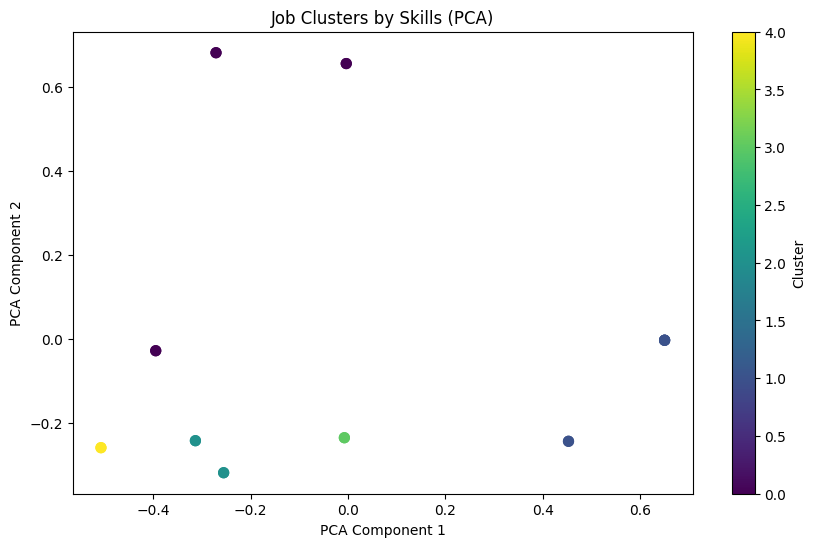

In [5]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X.toarray())

plt.figure(figsize=(10, 6))
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=df["Cluster"], cmap='viridis', s=50)
plt.title("Job Clusters by Skills (PCA)")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.colorbar(label="Cluster")
plt.show()


In [23]:

def split_skills(x):
    return x.split(',')

vectorizer = TfidfVectorizer(tokenizer=split_skills, lowercase=True)
X = vectorizer.fit_transform(df["Cleaned_Skills"])

import joblib

joblib.dump(kmeans, "job_cluster_model.pkl")
joblib.dump(vectorizer, "skill_vectorizer.pkl")
df.to_csv("clustered_job_postings.csv", index=False)

print("Model and vectorizer saved successfully!")



Model and vectorizer saved successfully!


/usr/local/lib/python3.11/dist-packages/sklearn/feature_extraction/text.py:517: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


In [8]:
def classify_new_jobs(new_df, user_skills):
    vec = joblib.load("skill_vectorizer.pkl")
    model = joblib.load("job_cluster_model.pkl")

    new_df["Cleaned_Skills"] = new_df["Skills"].apply(clean_skills)
    X_new = vec.transform(new_df["Cleaned_Skills"])
    new_df["Predicted_Cluster"] = model.predict(X_new)

    # Find cluster of user's skills
    user_vec = vec.transform([clean_skills(user_skills)])
    user_cluster = model.predict(user_vec)[0]

    print(f"User's skill set falls under cluster: {user_cluster}")
    return new_df[new_df["Predicted_Cluster"] == user_cluster]

# Simulate checking today’s jobs
user_input_skills = "python,data analysis,machine learning"
matched_jobs = classify_new_jobs(df_jobs, user_input_skills)
matched_jobs[["Title", "Company", "Skills", "Predicted_Cluster"]].head()


User's skill set falls under cluster: 1


,Title,Company,Skills,Predicted_Cluster
1,"Staff Software Engineer - Monetization, Poe (R...","Quora, Inc.","Aartificial intelligence,Analytical and Proble...",1
2,Staff Backend Engineer - Bot Creator Ecosystem...,"Quora, Inc.","Aartificial intelligence,API,Data science tech...",1
3,Senior Backend Engineer - Bot Creator Ecosyste...,"Quora, Inc.","Aartificial intelligence,API,Data science tech...",1
11,"Staff Software Engineer - Monetization, Poe (R...","Quora, Inc.","Aartificial intelligence,Analytical and Proble...",1
12,Staff Backend Engineer - Bot Creator Ecosystem...,"Quora, Inc.","Aartificial intelligence,API,Data science tech...",1


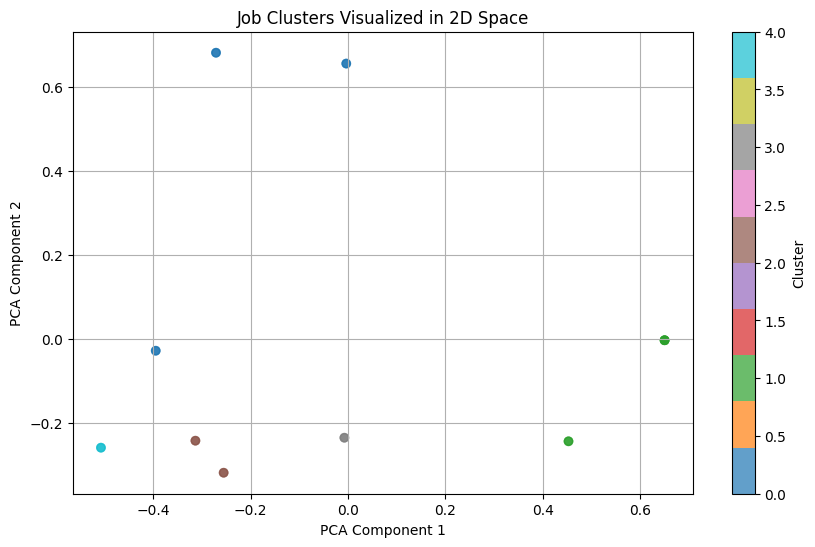

In [22]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# Prepare skill vectors for PCA
X_all = vectorizer.transform(df_jobs["Cleaned_Skills"])
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_all.toarray())

# Add PCA results to DataFrame
df_jobs["PCA1"] = X_pca[:, 0]
df_jobs["PCA2"] = X_pca[:, 1]

# Plotting
plt.figure(figsize=(10, 6))
scatter = plt.scatter(df_jobs["PCA1"], df_jobs["PCA2"], c=df_jobs["Predicted_Cluster"], cmap="tab10", alpha=0.7)
plt.title("Job Clusters Visualized in 2D Space")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.colorbar(scatter, label="Cluster")
plt.grid(True)
plt.show()


In [21]:
from collections import Counter

def top_skills_per_cluster(df, n=10):
    clusters = df["Predicted_Cluster"].unique()
    for cluster in sorted(clusters):
        print(f"\n Cluster {cluster}:")
        skill_list = df[df["Predicted_Cluster"] == cluster]["Cleaned_Skills"].str.cat(sep=",")
        skill_tokens = [skill.strip() for skill in skill_list.split(",") if skill.strip()]
        common = Counter(skill_tokens).most_common(n)
        for skill, count in common:
            print(f"  {skill} ({count} times)")

top_skills_per_cluster(df_jobs)



 Cluster 0:
  aartificial intelligence (6 times)
  large language models llms (6 times)
  machine learning techniques (6 times)
  natural language processing nlp (4 times)
  data science techniques (2 times)
  python programming (2 times)
  aws (2 times)
  azure (2 times)
  google cloud platform gcp (2 times)
  kubernetesk8s (2 times)

 Cluster 1:
  aartificial intelligence (6 times)
  api (6 times)
  design (6 times)
  effective communication skills (6 times)
  large language models llms (6 times)
  python programming (6 times)
  teamwork (6 times)
  data science techniques (4 times)
  analytical and problem solving (2 times)
  data analysis (2 times)

 Cluster 2:
  design (4 times)
  machine learning techniques (4 times)
  aartificial intelligence (2 times)
  algorithms (2 times)
  data structuring (2 times)
  leadership skill (2 times)

 Cluster 3:
  amazon redshift (2 times)
  apache hadoop (2 times)
  data science techniques (2 times)
  google bigquery (2 times)
  google cloud pl

<ipython-input-24-1a45118d8f9d>:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x="Predicted_Cluster", data=df_jobs, palette="Set2")


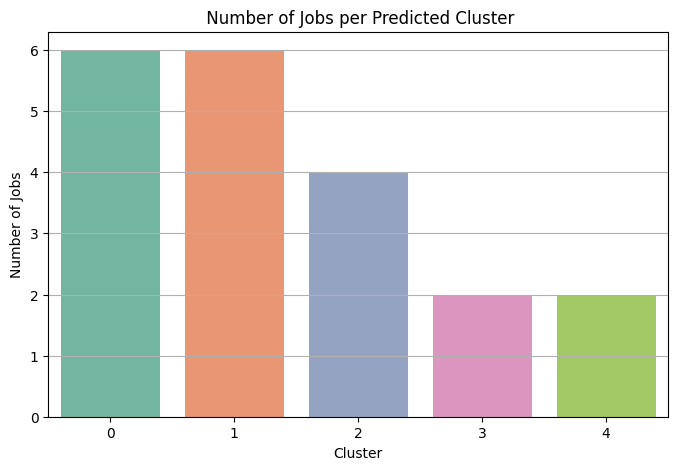

In [24]:
import seaborn as sns

plt.figure(figsize=(8, 5))
sns.countplot(x="Predicted_Cluster", data=df_jobs, palette="Set2")
plt.title(" Number of Jobs per Predicted Cluster")
plt.xlabel("Cluster")
plt.ylabel("Number of Jobs")
plt.grid(axis="y")
plt.show()


In [20]:
for cluster in sorted(df_jobs["Predicted_Cluster"].unique()):
    print(f"\n Sample Jobs from Cluster {cluster}")
    display(df_jobs[df_jobs["Predicted_Cluster"] == cluster][["Title", "Company", "Skills"]].head(3))



 Sample Jobs from Cluster 0


,Title,Company,Skills
4,Data Scientist Lead - AIML,JPMorgan Chase,"Aartificial intelligence,Data science techniqu..."
5,Applied AI ML Director - Machine Learning,JPMorgan Chase,"Aartificial intelligence,AWS,Azure,Google Clou..."
7,Manager - Machine Learning,Observe.AI,"Aartificial intelligence,Large Language Models..."



 Sample Jobs from Cluster 1


,Title,Company,Skills
1,"Staff Software Engineer - Monetization, Poe (R...","Quora, Inc.","Aartificial intelligence,Analytical and Proble..."
2,Staff Backend Engineer - Bot Creator Ecosystem...,"Quora, Inc.","Aartificial intelligence,API,Data science tech..."
3,Senior Backend Engineer - Bot Creator Ecosyste...,"Quora, Inc.","Aartificial intelligence,API,Data science tech..."



 Sample Jobs from Cluster 2


,Title,Company,Skills
0,Machine Learning Physical Design Engineer,Google,"Aartificial intelligence,Algorithms,Data struc..."
6,Senior Product Designer,Observe.AI,"Design,Leadership Skill,Machine learning techn..."
10,Machine Learning Physical Design Engineer,Google,"Aartificial intelligence,Algorithms,Data struc..."



 Sample Jobs from Cluster 3


,Title,Company,Skills
8,Data Scientist,Spotify,"Amazon RedShift,Apache Hadoop,Data science tec..."
18,Data Scientist,Spotify,"Amazon RedShift,Apache Hadoop,Data science tec..."



 Sample Jobs from Cluster 4


,Title,Company,Skills
9,ML Engineer,"CBRE Group, Inc.","Algorithms,Employee life cycle,Kubernetes-K8s,..."
19,ML Engineer,"CBRE Group, Inc.","Algorithms,Employee life cycle,Kubernetes-K8s,..."


# top TF-IDF skills per cluster

In [25]:

import numpy as np

feature_names = vectorizer.get_feature_names_out()
num_top_skills = 5

for cluster_num in range(kmeans.n_clusters):
    cluster_indices = df[df['Cluster'] == cluster_num].index
    cluster_skills_matrix = X[cluster_indices]
    avg_tfidf = cluster_skills_matrix.mean(axis=0).A1
    top_skill_indices = avg_tfidf.argsort()[::-1][:num_top_skills]
    top_skills = [feature_names[i] for i in top_skill_indices]
    print(f" Top {num_top_skills} Skills in Cluster {cluster_num}: {', '.join(top_skills)}")


 Top 5 Skills in Cluster 0: natural language processing nlp, machine learning techniques, large language models llms, aartificial intelligence, azure
 Top 5 Skills in Cluster 1: teamwork, effective communication skills, api, python programming, design
 Top 5 Skills in Cluster 2: design, leadership skill, machine learning techniques, data structuring, algorithms
 Top 5 Skills in Cluster 3: sql, r programming, apache hadoop, google bigquery, amazon redshift
 Top 5 Skills in Cluster 4: optimization, mlops tools, employee life cycle, kubernetesk8s, algorithms


# test on a new job description

In [19]:

new_job = ["Looking for an experienced backend developer with Python, Flask, and PostgreSQL expertise"]
new_vec = vectorizer.transform(new_job)
predicted_cluster = kmeans.predict(new_vec)[0]

print(f" Predicted Cluster for New Job: {predicted_cluster}")


 Predicted Cluster for New Job: 0


## Sample Jobs from Cluster 0

4	Data Scientist Lead -

AIML	JPMorgan Chase	Aartificial intelligence,Data science techniqu...


5	Applied AI ML Director -

 Machine Learning	JPMorgan Chase	Aartificial intelligence,AWS,Azure,Google Clou...


7	Manager -

Machine Learning	Observe.AI	Aartificial intelligence,Large Language Models...


# Save model and vectorizer

In [29]:
import joblib

joblib.dump(kmeans, "job_cluster_model.pkl")
joblib.dump(vectorizer, "skill_vectorizer.pkl")
print(" Model and vectorizer saved successfully!")


 Model and vectorizer saved successfully!


#Alerting System

In [28]:
# Example job input
new_job = ["Looking for an experienced backend developer with Python, Flask, and PostgreSQL expertise"]
new_vec = vectorizer.transform(new_job)
predicted_cluster = kmeans.predict(new_vec)[0]

# Alerting logic
target_cluster = 0
if predicted_cluster == target_cluster:
    print(" Alert: New job matches AI/ML cluster (Cluster 0)")
else:
    print(f"ℹJob falls into Cluster {predicted_cluster}")


 Alert: New job matches AI/ML cluster (Cluster 0)



# Each job got assigned a Cluster label (like 0, 1, 2...).

Jobs with similar content were grouped together, e.g.:

Cluster 0: Technical jobs like Data Analyst, Engineer.

Cluster 1: Management or HR-related roles.

Cluster 2: Marketing or writing roles.

Generated WordClouds for each cluster to visualize key terms